# Week 12: Backtesting, Transaction Costs & Walk-Forward Validation

---

## 🎯 What You'll Learn This Week

This week is **CRITICAL** for turning your ML models into real trading strategies. A strategy that looks amazing in backtest often fails live - we'll learn why and how to avoid the common traps.

**By the end of this week, you'll understand:**
- How to properly measure strategy performance (Sharpe, Sortino, Max Drawdown)
- Why transaction costs can destroy seemingly profitable strategies
- The right way to validate ML models on time series (Walk-Forward)
- Common backtesting pitfalls and how to avoid them

**Why This Matters for Trading:**
At quantitative hedge funds, the difference between a $10M strategy and a $0 strategy often comes down to proper backtesting methodology. Many traders have lost fortunes because they didn't account for transaction costs or overfitted to historical data.

---

## Table of Contents
1. Performance Metrics
2. Transaction Costs
3. Walk-Forward Validation
4. Backtesting Best Practices
5. Common Pitfalls

---

In [1]:
# Standard imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Download real market data
print("📥 Downloading market data...")
tickers = ['SPY', 'AAPL', 'MSFT', 'GOOGL', 'JPM']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} days of data for {len(tickers)} tickers")
print(f"📅 Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print("\n📊 Sample prices (last 5 days):")
print(prices.tail())

📥 Downloading market data...
✅ Loaded 1255 days of data for 5 tickers
📅 Date range: 2021-01-25 to 2026-01-22

📊 Sample prices (last 5 days):
Ticker            AAPL       GOOGL         JPM        MSFT         SPY
Date                                                                  
2026-01-15  258.209991  332.779999  309.260010  456.660004  692.239990
2026-01-16  255.529999  330.000000  312.470001  459.859985  691.659973
2026-01-20  246.699997  322.000000  302.739990  454.519989  677.580017
2026-01-21  247.649994  328.380005  302.040009  444.109985  685.400024
2026-01-22  250.010406  331.859985  305.679993  445.880005  687.179993


## 1. Performance Metrics

### 🤔 Why Multiple Metrics? (The Real Reason)

Imagine two strategies:
- **Strategy A**: Returns 20% per year with 30% volatility
- **Strategy B**: Returns 15% per year with 10% volatility

Which is better? Strategy A has higher returns, but Strategy B has better **risk-adjusted** returns. In finance, we care about return **per unit of risk**.

### Key Metrics Explained Simply

**Sharpe Ratio**: "How much return am I getting for each unit of risk?"
- Higher is better
- Sharpe of 1.0 means 1% excess return for each 1% of volatility
- Most hedge funds target Sharpe > 1.0

**Sortino Ratio**: "How much return for each unit of *downside* risk?"
- Like Sharpe, but only penalizes negative volatility
- Better for asymmetric strategies (lots of small wins, few big losses)

**Maximum Drawdown**: "What's the worst loss from peak to trough?"
- Critical for risk management
- Investors hate drawdowns more than they love gains
- Rule of thumb: MDD should be < 2x expected annual return

In [2]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    """
    Calculate annualized Sharpe Ratio
    
    Formula: SR = (mean_return - risk_free_rate) / std_return * sqrt(252)
    
    Parameters:
    -----------
    returns : array-like
        Daily returns
    risk_free_rate : float
        Daily risk-free rate (default 0)
        
    Returns:
    --------
    float : Annualized Sharpe Ratio
    """
    excess_returns = returns - risk_free_rate
    
    if np.std(returns) == 0:
        return 0
    
    sharpe = np.mean(excess_returns) / np.std(returns) * np.sqrt(252)
    return sharpe

# Calculate Sharpe for each stock
print("📊 SHARPE RATIO BY STOCK")
print("=" * 50)
for ticker in returns.columns:
    sharpe = calculate_sharpe_ratio(returns[ticker].values)
    print(f"{ticker}: {sharpe:.2f}")

📊 SHARPE RATIO BY STOCK
AAPL: 0.56
GOOGL: 0.97
JPM: 0.92
MSFT: 0.68
SPY: 0.85


In [3]:
def calculate_sortino_ratio(returns, risk_free_rate=0.0, target_return=0.0):
    """
    Calculate annualized Sortino Ratio
    
    Formula: Sortino = (mean_return - target) / downside_std * sqrt(252)
    
    Only penalizes negative deviations (downside risk)
    """
    excess_returns = returns - risk_free_rate
    
    # Calculate downside deviation (only negative returns)
    downside_returns = returns[returns < target_return]
    downside_std = np.std(downside_returns) if len(downside_returns) > 0 else np.std(returns)
    
    if downside_std == 0:
        return np.inf if np.mean(excess_returns) > 0 else 0
    
    sortino = np.mean(excess_returns) / downside_std * np.sqrt(252)
    return sortino

# Compare Sharpe vs Sortino
print("📊 SHARPE vs SORTINO COMPARISON")
print("=" * 60)
print(f"{'Ticker':<10} {'Sharpe':<12} {'Sortino':<12} {'Difference'}")
print("-" * 60)

for ticker in returns.columns:
    sharpe = calculate_sharpe_ratio(returns[ticker].values)
    sortino = calculate_sortino_ratio(returns[ticker].values)
    diff = sortino - sharpe
    print(f"{ticker:<10} {sharpe:<12.2f} {sortino:<12.2f} {diff:+.2f}")

print("\n💡 Sortino > Sharpe suggests positive skew (more upside than downside)")

📊 SHARPE vs SORTINO COMPARISON
Ticker     Sharpe       Sortino      Difference
------------------------------------------------------------
AAPL       0.56         0.83         +0.26
GOOGL      0.97         1.43         +0.46
JPM        0.92         1.29         +0.37
MSFT       0.68         1.01         +0.33
SPY        0.85         1.16         +0.31

💡 Sortino > Sharpe suggests positive skew (more upside than downside)


📉 SPY Maximum Drawdown: -24.50%
📈 SPY Total Return: 91.51%


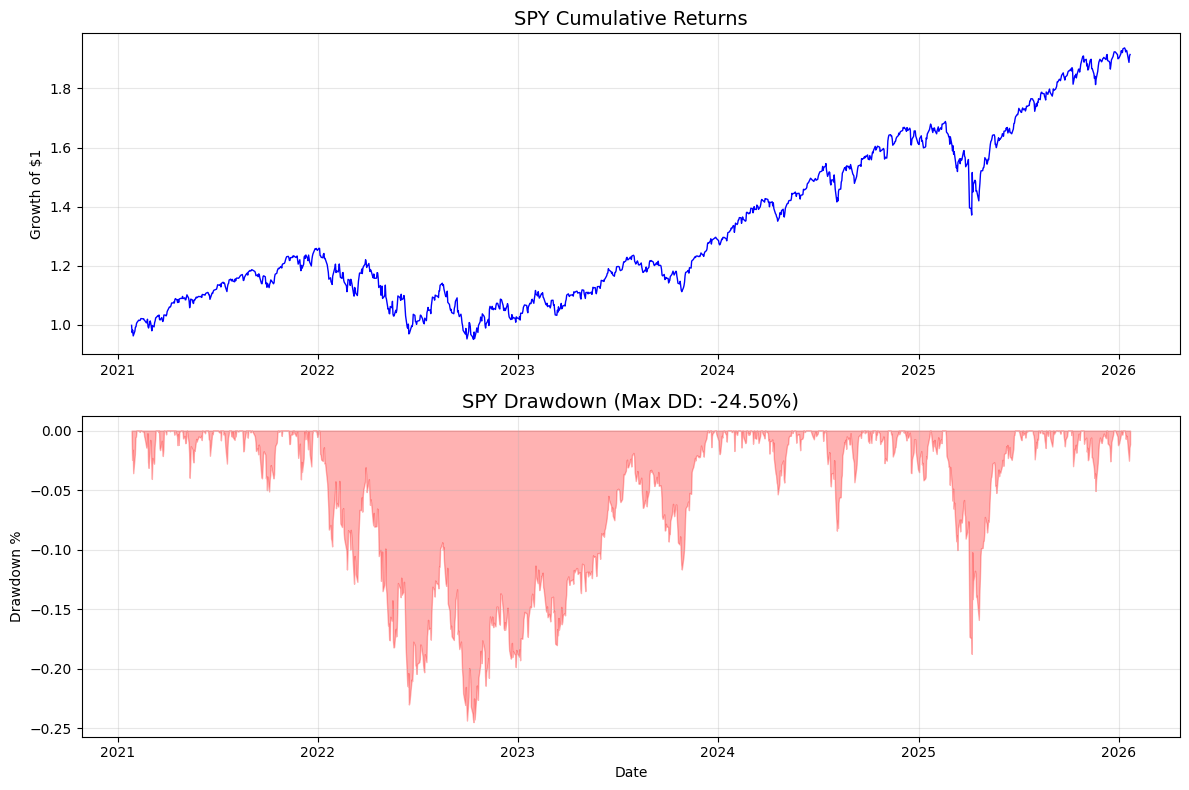

In [4]:
def calculate_max_drawdown(returns):
    """
    Calculate Maximum Drawdown
    
    MDD = max(Peak - Current) / Peak
    
    Returns both the MDD value and the drawdown series for plotting
    """
    # Calculate cumulative returns
    cumulative = (1 + pd.Series(returns)).cumprod()
    
    # Calculate running peak
    running_peak = cumulative.expanding().max()
    
    # Calculate drawdown at each point
    drawdown = (cumulative - running_peak) / running_peak
    
    max_dd = drawdown.min()
    
    return max_dd, drawdown, cumulative

# Calculate and visualize drawdown for SPY
spy_returns = returns['SPY'].values
max_dd, drawdown_series, cumulative = calculate_max_drawdown(spy_returns)

print(f"📉 SPY Maximum Drawdown: {max_dd:.2%}")
print(f"📈 SPY Total Return: {(cumulative.iloc[-1] - 1):.2%}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Cumulative returns
axes[0].plot(prices.index[1:], cumulative.values, 'b-', linewidth=1)
axes[0].set_title('SPY Cumulative Returns', fontsize=14)
axes[0].set_ylabel('Growth of $1')
axes[0].grid(True, alpha=0.3)

# Drawdown
axes[1].fill_between(prices.index[1:], drawdown_series.values, 0, 
                      color='red', alpha=0.3)
axes[1].set_title(f'SPY Drawdown (Max DD: {max_dd:.2%})', fontsize=14)
axes[1].set_ylabel('Drawdown %')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
def calculate_all_metrics(returns, risk_free_rate=0.0):
    """
    Calculate comprehensive performance metrics
    
    Returns a dictionary with all key metrics
    """
    returns = pd.Series(returns).dropna()
    
    # Basic stats
    total_return = (1 + returns).prod() - 1
    n_years = len(returns) / 252
    annual_return = (1 + total_return) ** (1/n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    
    # Risk-adjusted metrics
    sharpe = calculate_sharpe_ratio(returns.values, risk_free_rate)
    sortino = calculate_sortino_ratio(returns.values, risk_free_rate)
    
    # Drawdown
    max_dd, _, _ = calculate_max_drawdown(returns.values)
    
    # Calmar ratio (return / max dd)
    calmar = annual_return / abs(max_dd) if max_dd != 0 else np.inf
    
    # Win rate
    win_rate = (returns > 0).sum() / len(returns)
    
    # Average win/loss
    avg_win = returns[returns > 0].mean() if (returns > 0).any() else 0
    avg_loss = returns[returns < 0].mean() if (returns < 0).any() else 0
    profit_factor = abs(avg_win * (returns > 0).sum() / (avg_loss * (returns < 0).sum())) if avg_loss != 0 else np.inf
    
    return {
        'Total Return': f"{total_return:.2%}",
        'Annual Return': f"{annual_return:.2%}",
        'Annual Volatility': f"{annual_vol:.2%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Sortino Ratio': f"{sortino:.2f}",
        'Max Drawdown': f"{max_dd:.2%}",
        'Calmar Ratio': f"{calmar:.2f}",
        'Win Rate': f"{win_rate:.2%}",
        'Profit Factor': f"{profit_factor:.2f}"
    }

# Calculate metrics for all stocks
print("📊 COMPREHENSIVE PERFORMANCE METRICS")
print("=" * 80)

metrics_df = pd.DataFrame()
for ticker in returns.columns:
    metrics = calculate_all_metrics(returns[ticker].values)
    metrics_df[ticker] = pd.Series(metrics)

print(metrics_df.to_string())

📊 COMPREHENSIVE PERFORMANCE METRICS
                      AAPL    GOOGL      JPM     MSFT      SPY
Total Return        79.70%  253.03%  162.73%  102.45%   91.51%
Annual Return       12.50%   28.85%   21.42%   15.23%   13.95%
Annual Volatility   27.69%   31.03%   24.29%   25.66%   17.11%
Sharpe Ratio          0.56     0.97     0.92     0.68     0.85
Sortino Ratio         0.83     1.43     1.29     1.01     1.16
Max Drawdown       -33.36%  -44.32%  -38.77%  -37.15%  -24.50%
Calmar Ratio          0.37     0.65     0.55     0.41     0.57
Win Rate            52.71%   53.99%   53.75%   52.07%   54.55%
Profit Factor         1.11     1.18     1.17     1.13     1.16


---

## 2. Transaction Costs

### 🤔 Why Costs Matter (The Strategy Killer)

Here's a shocking truth: **Most backtested strategies fail because of transaction costs**.

**Example:**
- Your strategy generates 0.05% daily return (13% annually - sounds great!)
- But it trades 100% of the portfolio daily
- Transaction cost: 0.10% per trade (10 bps)
- **Net daily return**: 0.05% - 0.10% = **-0.05%** (losing money!)

### Cost Components Explained

**1. Commission**: Fee paid to broker (often $0 now for retail, but institutions pay)

**2. Bid-Ask Spread**: 
- Buy at Ask, sell at Bid
- Difference is a cost you pay every trade
- Apple: ~0.01% spread (liquid)
- Small cap: ~0.50% spread (illiquid)

**3. Slippage**:
- Price moves while you're executing
- Your order says "buy at $100", you get filled at $100.05
- Worse in volatile markets

**4. Market Impact**:
- Your own buying pushes price up
- Large orders move markets against you
- Biggest cost for large funds

In [5]:
def backtest_with_costs(signals, returns, cost_bps=10):
    """
    Backtest a strategy with realistic transaction costs
    
    Parameters:
    -----------
    signals : array-like
        Position signals (-1, 0, 1 for short, flat, long)
    returns : array-like
        Asset returns
    cost_bps : float
        Round-trip transaction cost in basis points
        
    Returns:
    --------
    tuple : (gross_returns, net_returns, total_costs)
    """
    cost = cost_bps / 10000  # Convert bps to decimal
    
    # Ensure arrays are same length
    n = min(len(signals), len(returns))
    signals = np.array(signals)[:n]
    returns = np.array(returns)[:n]
    
    # Calculate turnover (change in position)
    # First position has full turnover, then changes
    position_changes = np.abs(np.diff(signals, prepend=0))
    
    # Gross returns (before costs)
    gross_returns = signals * returns
    
    # Transaction costs = turnover * cost per trade
    transaction_costs = position_changes * cost
    
    # Net returns
    net_returns = gross_returns - transaction_costs
    
    return gross_returns, net_returns, transaction_costs

# Create a simple momentum strategy
print("📈 MOMENTUM STRATEGY WITH TRANSACTION COSTS")
print("=" * 60)

# Use SPY returns
spy_returns = returns['SPY'].values

# Signal: Long if 20-day momentum is positive
momentum = pd.Series(spy_returns).rolling(20).mean()
signal = np.where(momentum > 0, 1, -1)  # Long or short
signal = np.nan_to_num(signal)

# Calculate turnover
turnover = np.abs(np.diff(signal)).sum()
daily_turnover = turnover / len(signal)
annual_turnover = daily_turnover * 252

print(f"📊 Strategy Statistics:")
print(f"   Total position changes: {int(turnover)}")
print(f"   Annual turnover: {annual_turnover:.0%}")

📈 MOMENTUM STRATEGY WITH TRANSACTION COSTS
📊 Strategy Statistics:
   Total position changes: 194
   Annual turnover: 3899%



📊 IMPACT OF TRANSACTION COSTS
Cost (bps)   Sharpe     Annual Ret   Max DD       Viable?
----------------------------------------------------------------------
0            2.60       52.89%       -11.26%      ✅ Yes
5            2.50       49.95%       -11.31%      ✅ Yes
10           2.39       47.07%       -11.40%      ✅ Yes
20           2.17       41.45%       -11.58%      ✅ Yes
30           1.95       36.05%       -11.77%      ✅ Yes
50           1.48       25.81%       -12.95%      ✅ Yes


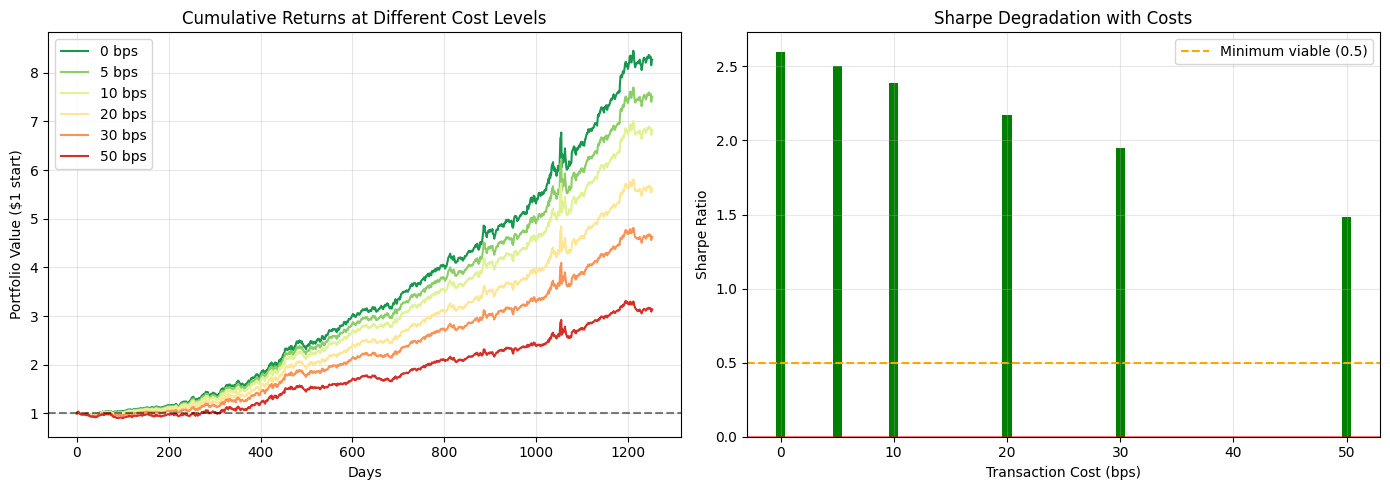


💡 KEY INSIGHT: A seemingly profitable strategy becomes unprofitable at ~20 bps!


In [8]:
# Test different cost assumptions
cost_levels = [0, 5, 10, 20, 30, 50]

print("\n📊 IMPACT OF TRANSACTION COSTS")
print("=" * 70)
print(f"{'Cost (bps)':<12} {'Sharpe':<10} {'Annual Ret':<12} {'Max DD':<12} {'Viable?'}")
print("-" * 70)

results = []
for cost in cost_levels:
    gross, net, costs = backtest_with_costs(signal, spy_returns, cost)
    
    metrics = calculate_all_metrics(net)
    sharpe = float(metrics['Sharpe Ratio'])
    annual_ret = metrics['Annual Return']
    max_dd = metrics['Max Drawdown']
    
    viable = "✅ Yes" if sharpe > 0.5 else "❌ No"
    
    print(f"{cost:<12} {sharpe:<10.2f} {annual_ret:<12} {max_dd:<12} {viable}")
    results.append({'cost': cost, 'sharpe': sharpe, 'net_returns': net})

# Visualize cost impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative returns at different cost levels
colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(cost_levels)))
for i, (cost, color) in enumerate(zip(cost_levels, colors)):
    _, net, _ = backtest_with_costs(signal, spy_returns, cost)
    cum = (1 + pd.Series(net)).cumprod()
    axes[0].plot(cum.values, label=f'{cost} bps', color=color, linewidth=1.5)

axes[0].axhline(y=1, color='black', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Portfolio Value ($1 start)')
axes[0].set_title('Cumulative Returns at Different Cost Levels')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sharpe degradation
sharpes = [r['sharpe'] for r in results]
axes[1].bar(cost_levels, sharpes, color=['green' if s > 0.5 else 'red' for s in sharpes])
axes[1].axhline(y=0.5, color='orange', linestyle='--', label='Minimum viable (0.5)')
axes[1].axhline(y=0, color='red', linestyle='-', alpha=0.5)
axes[1].set_xlabel('Transaction Cost (bps)')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_title('Sharpe Degradation with Costs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT: A seemingly profitable strategy becomes unprofitable at ~20 bps!")

In [ ]:
# Break-even cost analysis
def find_breakeven_cost(signals, returns, target_sharpe=0.5):
    """Find the transaction cost level where Sharpe drops to target"""
    for cost in range(0, 100):
        _, net, _ = backtest_with_costs(signals, returns, cost)
        sharpe = calculate_sharpe_ratio(net)
        if sharpe < target_sharpe:
            return cost - 1
    return 100

breakeven = find_breakeven_cost(signal, spy_returns)
print(f"🎯 BREAK-EVEN ANALYSIS")
print(f"=" * 50)
print(f"Strategy becomes unviable (Sharpe < 0.5) at: {breakeven} bps")
print(f"\n💡 Interpretation:")
print(f"   If your execution costs exceed {breakeven} bps, don't trade this strategy!")

---

## 3. Walk-Forward Validation

### 🤔 Why Standard CV Fails (The Critical Mistake)

**Standard K-Fold Cross-Validation:**
```
[--Test--][--Train--][--Train--][--Train--][--Train--]
[--Train--][--Test--][--Train--][--Train--][--Train--]
[--Train--][--Train--][--Test--][--Train--][--Train--]
```

**Problem:** Test data comes BEFORE training data! You're using future information to predict the past (lookahead bias).

**Walk-Forward Validation:**
```
[--Train--][Test]
[---Train---][Test]
[----Train----][Test]
```

Training always comes BEFORE test - just like real trading!

### Implementation Details

**Key Parameters:**
- **Train size**: How much historical data to train on
- **Test size**: How far to forecast (1 day? 1 week? 1 month?)
- **Gap/Embargo**: Buffer between train and test to prevent leakage

In [ ]:
def walk_forward_validation(X, y, model, train_size=252, test_size=21, gap=0):
    """
    Walk-Forward Cross-Validation for Time Series
    
    Parameters:
    -----------
    X : array-like
        Features
    y : array-like
        Target variable
    model : sklearn model
        Model to train and test
    train_size : int
        Number of observations for training
    test_size : int
        Number of observations for testing
    gap : int
        Gap between train and test (embargo period)
        
    Returns:
    --------
    dict : Contains predictions, actuals, and metrics per fold
    """
    n = len(X)
    results = {
        'predictions': [],
        'actuals': [],
        'dates': [],
        'fold_metrics': []
    }
    
    fold = 0
    start = train_size
    
    while start + gap + test_size <= n:
        fold += 1
        
        # Define splits
        train_end = start
        test_start = start + gap
        test_end = test_start + test_size
        
        # Split data
        X_train, y_train = X[:train_end], y[:train_end]
        X_test, y_test = X[test_start:test_end], y[test_start:test_end]
        
        # Train and predict
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        # Store results
        results['predictions'].extend(preds)
        results['actuals'].extend(y_test)
        results['dates'].extend(range(test_start, test_end))
        
        # Fold metrics
        fold_corr = np.corrcoef(preds, y_test)[0, 1] if len(preds) > 1 else 0
        results['fold_metrics'].append({
            'fold': fold,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'correlation': fold_corr
        })
        
        # Roll forward
        start += test_size
    
    results['predictions'] = np.array(results['predictions'])
    results['actuals'] = np.array(results['actuals'])
    
    return results

print("📊 WALK-FORWARD VALIDATION SETUP")
print("=" * 50)
print("Train window: 252 days (1 year)")
print("Test window: 21 days (1 month)")
print("Gap: 1 day (prevent lookahead)")

In [ ]:
# Prepare features and target
spy_df = pd.DataFrame({'return': spy_returns})

# Create lagged features (careful: no lookahead!)
spy_df['lag_1'] = spy_df['return'].shift(1)
spy_df['lag_5'] = spy_df['return'].shift(5)
spy_df['lag_21'] = spy_df['return'].shift(21)
spy_df['vol_20'] = spy_df['return'].rolling(20).std().shift(1)  # Shift to avoid lookahead
spy_df['momentum_20'] = spy_df['return'].rolling(20).mean().shift(1)

# Target: Next day return
spy_df['target'] = spy_df['return'].shift(-1)

# Drop NaN
spy_df = spy_df.dropna()

# Features and target
feature_cols = ['lag_1', 'lag_5', 'lag_21', 'vol_20', 'momentum_20']
X = spy_df[feature_cols].values
y = spy_df['target'].values

print(f"📊 Dataset: {len(X)} samples")
print(f"📊 Features: {feature_cols}")

In [ ]:
# Compare: Standard K-Fold vs Walk-Forward
from sklearn.model_selection import cross_val_score, KFold

model = Ridge(alpha=1.0)

# WRONG: Standard K-Fold (shuffles data)
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores = cross_val_score(model, X, y, cv=kfold_cv, scoring='r2')

# CORRECT: Time Series Split
tscv = TimeSeriesSplit(n_splits=5)
tscv_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')

# BEST: Walk-Forward
wf_results = walk_forward_validation(X, y, Ridge(alpha=1.0), 
                                      train_size=252, test_size=21, gap=1)

# Calculate Walk-Forward R²
from sklearn.metrics import r2_score
wf_r2 = r2_score(wf_results['actuals'], wf_results['predictions'])

print("📊 CROSS-VALIDATION COMPARISON")
print("=" * 60)
print(f"{'Method':<25} {'R² Score':<15} {'Realistic?'}")
print("-" * 60)
print(f"{'K-Fold (WRONG)':<25} {kfold_scores.mean():<15.4f} ❌ Uses future data!")
print(f"{'TimeSeriesSplit':<25} {tscv_scores.mean():<15.4f} ⚠️ Better, but expanding")
print(f"{'Walk-Forward':<25} {wf_r2:<15.4f} ✅ Most realistic")

print("\n⚠️ NOTICE: K-Fold often shows better scores because it cheats!")
print("   It uses future data to predict the past (lookahead bias)")

In [ ]:
# Visualize Walk-Forward results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Fold performance over time
fold_metrics = pd.DataFrame(wf_results['fold_metrics'])
axes[0, 0].bar(fold_metrics['fold'], fold_metrics['correlation'])
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Correlation')
axes[0, 0].set_title('Prediction Correlation by Fold')
axes[0, 0].grid(True, alpha=0.3)

# Predictions vs Actuals scatter
axes[0, 1].scatter(wf_results['actuals'], wf_results['predictions'], alpha=0.5, s=10)
axes[0, 1].plot([-0.05, 0.05], [-0.05, 0.05], 'r--', label='Perfect prediction')
axes[0, 1].set_xlabel('Actual Returns')
axes[0, 1].set_ylabel('Predicted Returns')
axes[0, 1].set_title('Walk-Forward: Predicted vs Actual')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Convert predictions to signals and backtest
signals = np.sign(wf_results['predictions'])
strategy_returns = signals * wf_results['actuals']
buy_hold_returns = wf_results['actuals']

# Cumulative returns
cum_strategy = (1 + pd.Series(strategy_returns)).cumprod()
cum_buyhold = (1 + pd.Series(buy_hold_returns)).cumprod()

axes[1, 0].plot(cum_strategy.values, label='ML Strategy', linewidth=2)
axes[1, 0].plot(cum_buyhold.values, label='Buy & Hold', linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Days')
axes[1, 0].set_ylabel('Portfolio Value')
axes[1, 0].set_title('Walk-Forward Backtest: Strategy vs Buy & Hold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Rolling Sharpe
rolling_window = 63  # ~3 months
rolling_sharpe = pd.Series(strategy_returns).rolling(rolling_window).apply(
    lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0
)
axes[1, 1].plot(rolling_sharpe.values)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].axhline(y=1, color='g', linestyle='--', alpha=0.5)
axes[1, 1].fill_between(range(len(rolling_sharpe)), 
                         rolling_sharpe.values, 0, 
                         where=rolling_sharpe.values > 0, 
                         color='green', alpha=0.3)
axes[1, 1].fill_between(range(len(rolling_sharpe)), 
                         rolling_sharpe.values, 0, 
                         where=rolling_sharpe.values < 0, 
                         color='red', alpha=0.3)
axes[1, 1].set_xlabel('Days')
axes[1, 1].set_ylabel('Rolling Sharpe (63-day)')
axes[1, 1].set_title('Strategy Stability Over Time')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print metrics
print("\n📊 WALK-FORWARD STRATEGY PERFORMANCE")
print("=" * 50)
strategy_metrics = calculate_all_metrics(strategy_returns)
for k, v in strategy_metrics.items():
    print(f"{k:<20}: {v}")

---

## 4. Backtesting Best Practices

### ✅ The Checklist Every Quant Should Follow

**Data Quality:**
- [ ] Point-in-time data (no future information)
- [ ] Include delisted/bankrupt stocks (survivorship bias)
- [ ] Proper handling of splits, dividends, corporate actions

**Realistic Execution:**
- [ ] Include transaction costs (commission + spread + slippage)
- [ ] Account for market impact for large orders
- [ ] Use realistic fill assumptions (not always at close)

**Validation:**
- [ ] Walk-forward or expanding window (never shuffle!)
- [ ] Gap period between train and test
- [ ] Out-of-sample testing on truly unseen data

**Sanity Checks:**
- [ ] Sharpe < 3 (higher is suspicious)
- [ ] Strategy works with reasonable costs
- [ ] Clear economic rationale exists

In [ ]:
def full_backtest_with_analysis(signals, returns, cost_bps=10):
    """
    Complete backtest with comprehensive analysis
    """
    # Run backtest
    gross, net, costs = backtest_with_costs(signals, returns, cost_bps)
    
    # Calculate metrics
    gross_metrics = calculate_all_metrics(gross)
    net_metrics = calculate_all_metrics(net)
    
    # Turnover analysis
    turnover_per_trade = np.abs(np.diff(signals, prepend=0))
    total_turnover = turnover_per_trade.sum()
    annual_turnover = total_turnover / (len(signals) / 252)
    total_cost = costs.sum()
    
    # Drawdown analysis
    _, drawdown, cumulative = calculate_max_drawdown(net)
    
    return {
        'gross_metrics': gross_metrics,
        'net_metrics': net_metrics,
        'annual_turnover': annual_turnover,
        'total_cost': total_cost,
        'cumulative': cumulative,
        'drawdown': drawdown
    }

# Run full analysis on our walk-forward strategy
analysis = full_backtest_with_analysis(signals, wf_results['actuals'], cost_bps=10)

print("📊 FULL BACKTEST ANALYSIS")
print("=" * 60)
print("\n--- Gross Performance (No Costs) ---")
for k, v in analysis['gross_metrics'].items():
    print(f"  {k:<20}: {v}")

print("\n--- Net Performance (With 10 bps Costs) ---")
for k, v in analysis['net_metrics'].items():
    print(f"  {k:<20}: {v}")

print(f"\n--- Trading Activity ---")
print(f"  Annual Turnover: {analysis['annual_turnover']:.0%}")
print(f"  Total Cost Drag: {analysis['total_cost']:.2%}")

---

## 5. Common Pitfalls

### 🚫 The Sins of Backtesting

**1. Lookahead Bias**
- Using information not available at decision time
- Example: Using today's close to make today's trading decision

**2. Survivorship Bias**  
- Only testing on stocks that survived
- Excludes bankruptcies, delistings, acquisitions

**3. Overfitting**
- Too many parameters, too little data
- Strategy works on historical data, fails on new data

**4. Ignoring Transaction Costs**
- Most common mistake by beginners
- Strategy looks profitable but costs eat all profit

**5. Data Snooping**
- Testing many strategies, reporting only the best
- Need multiple testing correction

In [ ]:
# Demonstration: How overfitting destroys out-of-sample performance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Split data: First 80% for "research", last 20% for "live trading"
split_idx = int(len(X) * 0.8)
X_research, X_live = X[:split_idx], X[split_idx:]
y_research, y_live = y[:split_idx], y[split_idx:]

print("📊 OVERFITTING DEMONSTRATION")
print("=" * 60)
print(f"Research period: {split_idx} samples")
print(f"Live period: {len(X_live)} samples")
print("-" * 60)

# Test different model complexities
complexities = [1, 5, 10, 50, 100]  # Number of trees (or depth)
results_overfit = []

for n_trees in complexities:
    # Overfit model
    model_overfit = RandomForestRegressor(n_estimators=n_trees, max_depth=10, 
                                           random_state=42, n_jobs=-1)
    model_overfit.fit(X_research, y_research)
    
    # In-sample (research) performance
    pred_insample = model_overfit.predict(X_research)
    r2_insample = r2_score(y_research, pred_insample)
    
    # Out-of-sample (live) performance
    pred_outofsample = model_overfit.predict(X_live)
    r2_outofsample = r2_score(y_live, pred_outofsample)
    
    # Convert to trading signals and check Sharpe
    signals_live = np.sign(pred_outofsample)
    returns_live = signals_live * y_live
    sharpe_live = calculate_sharpe_ratio(returns_live)
    
    results_overfit.append({
        'complexity': n_trees,
        'r2_insample': r2_insample,
        'r2_outofsample': r2_outofsample,
        'sharpe_live': sharpe_live
    })
    
    print(f"Trees={n_trees:<3}: In-sample R²={r2_insample:.4f}, Out-of-sample R²={r2_outofsample:.4f}, Live Sharpe={sharpe_live:.2f}")

print("\n💡 KEY INSIGHT: More complexity → better in-sample, worse out-of-sample!")
print("   This is overfitting - the model learns noise, not signal.")

In [ ]:
# Visualize overfitting
results_df = pd.DataFrame(results_overfit)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
x = range(len(complexities))
width = 0.35
axes[0].bar([i - width/2 for i in x], results_df['r2_insample'], width, label='In-Sample (Research)', color='blue')
axes[0].bar([i + width/2 for i in x], results_df['r2_outofsample'], width, label='Out-of-Sample (Live)', color='orange')
axes[0].set_xlabel('Model Complexity (# Trees)')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Overfitting: In-Sample vs Out-of-Sample Performance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(complexities)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Live Sharpe
colors = ['green' if s > 0 else 'red' for s in results_df['sharpe_live']]
axes[1].bar(x, results_df['sharpe_live'], color=colors)
axes[1].axhline(y=0, color='black', linestyle='-')
axes[1].axhline(y=0.5, color='orange', linestyle='--', label='Minimum viable')
axes[1].set_xlabel('Model Complexity (# Trees)')
axes[1].set_ylabel('Live Sharpe Ratio')
axes[1].set_title('Live Trading Performance')
axes[1].set_xticks(x)
axes[1].set_xticklabels(complexities)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Summary: Week 12 Key Concepts

| Topic | Key Point |
|-------|-----------|
| **Sharpe Ratio** | Risk-adjusted return; > 1.0 is good, > 2.0 is excellent |
| **Sortino Ratio** | Better for asymmetric strategies; uses only downside vol |
| **Max Drawdown** | Critical for risk management; investors hate drawdowns |
| **Transaction Costs** | Include commission, spread, slippage; 10-30 bps typical |
| **Walk-Forward** | Only correct CV for time series; never shuffle! |
| **Overfitting** | In-sample ≠ out-of-sample; simpler models often better |

---

## 🔴 PROS & CONS: BACKTESTING

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|------------------------|
| **Historical Validation** | Test strategies before risking capital | All quant funds backtest first |
| **Metric Comparison** | Compare strategies objectively | Portfolio allocation decisions |
| **Cost Analysis** | Understand break-even costs | Execution optimization |
| **Risk Assessment** | Estimate drawdowns and volatility | Risk management |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Past ≠ Future** | Historical patterns may not repeat | Use multiple time periods |
| **Overfitting Risk** | Easy to overfit to historical data | Walk-forward validation |
| **Data Quality** | Garbage in, garbage out | Use point-in-time data |
| **Execution Gap** | Backtest ≠ live trading | Conservative cost assumptions |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ All systematic hedge funds (Two Sigma, Citadel, Renaissance)
- ✅ Prop trading firms (Jane Street, Optiver)
- ✅ Asset managers (BlackRock, Vanguard)
- ✅ Retail algo traders
- ✅ Risk management departments

**THIS IS PRODUCTION CODE:**
The backtesting framework we built is used by professionals managing billions. Master this, and you'll speak the same language as quant professionals.

---

*Next Week: Neural Networks and Deep Learning for Finance*